#### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import requests
from io import BytesIO
from zipfile import ZipFile, BadZipFile

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from sklearn.datasets import fetch_openml

pd.set_option('display.expand_frame_repr', False)

##### Data Directory

In [2]:
from pathlib import Path

DATA_PATH = Path('/home/sayem/Desktop/Project/data')
DATA_STORE = Path('/home/sayem/Desktop/Project/data/assets.h5')

##### S&P 500 Prices

In [3]:
df = web.DataReader(name='SP500', data_source='fred', start=2009).squeeze().to_frame('close')
print(df.info())
with pd.HDFStore(DATA_STORE) as store:
    store.put('sp500/fred_price', df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2610 entries, 2013-09-23 to 2023-09-22
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   2518 non-null   float64
dtypes: float64(1)
memory usage: 40.8 KB
None


In [4]:
sp500_stooq = (pd.read_csv(DATA_PATH / '^spx_d.csv', index_col=0,
                     parse_dates=True).loc['1950':'2023'].rename(columns=str.lower))
                     
print(sp500_stooq.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18628 entries, 1950-01-03 to 2023-09-08
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    18628 non-null  float64
 1   high    18628 non-null  float64
 2   low     18628 non-null  float64
 3   close   18628 non-null  float64
 4   volume  18628 non-null  float64
dtypes: float64(5)
memory usage: 873.2 KB
None


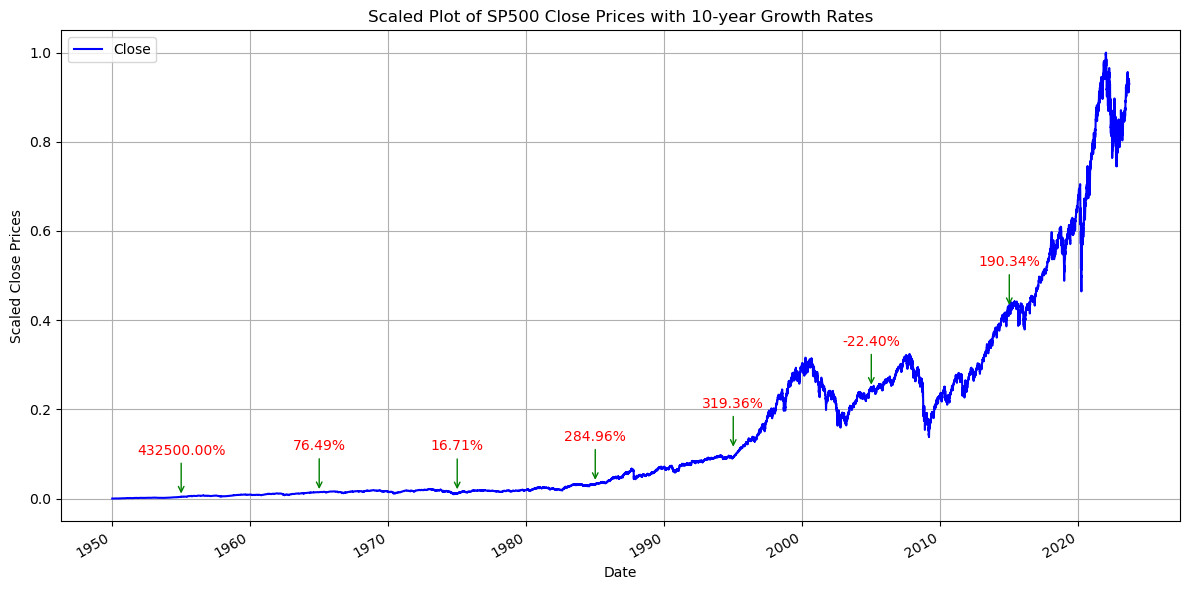

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Extracting the close column
close_prices = sp500_stooq['close'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_close_prices = scaler.fit_transform(close_prices)

sp500_stooq_scaled_close = pd.Series(scaled_close_prices.ravel(), index=sp500_stooq.index)

ax = sp500_stooq_scaled_close.plot(figsize=(12, 6), color='blue')

# Calculate the growth rate for each 10-year interval
dates = sp500_stooq_scaled_close.index
start_year = dates.min().year
end_year = dates.max().year

for year in range(start_year, end_year - 9, 10):
    start_price = sp500_stooq_scaled_close[sp500_stooq_scaled_close.index.year == year].iloc[0]
    end_price = sp500_stooq_scaled_close[sp500_stooq_scaled_close.index.year == year + 10].iloc[0]
    growth_rate = ((end_price - start_price) / start_price) * 100

    # Annotate the plot with these growth rates
    annotation = f"{growth_rate:.2f}%"
    position = sp500_stooq_scaled_close[sp500_stooq_scaled_close.index.year == year + 5].mean()
    ax.annotate(annotation, 
                xy=(f"{year + 5}-01-01", position), 
                xytext=(0, 30),  # Offset the text by 30 points upward
                textcoords="offset points",
                color="red",
                ha='center', 
                fontsize=10, 
                arrowprops=dict(arrowstyle='->', color='green'))

plt.title("Scaled Plot of SP500 Close Prices with 10-year Growth Rates")
plt.ylabel("Scaled Close Prices")
plt.xlabel("Date")
plt.grid(True)
plt.legend(['Close'])
plt.tight_layout()
plt.show()


##### S&P 500 Constituents

In [6]:
import pandas as pd

url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
df = pd.read_html(url, header=0)[0]

# Drop rows containing NaN values
df_cleaned = df.dropna()

In [7]:
df.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [8]:
df.columns = ['ticker', 'name', 'gics_sector', 'gics_sub_industry',
              'location', 'first_added', 'cik', 'founded']
df = df.set_index('ticker')

In [9]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('sp500/stocks_name', df)

##### Metadata on US-traded companies

In [10]:
from pathlib import Path
import pandas as pd

csv_folder = DATA_PATH / 'csv'

# List all files ending with _screener.csv in the csv folder
csv_files = list(csv_folder.glob('*_screener.csv'))

# Load all these CSVs into a DataFrame
all_data = [pd.read_csv(file) for file in csv_files]
df = pd.concat(all_data, ignore_index=True)

# Rename columns, set index, and remove duplicates
df = df.rename(columns=str.lower).set_index('symbol')
df = df[~df.index.duplicated()]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7516 entries, AACG to ZWS
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        7516 non-null   object 
 1   last sale   7516 non-null   object 
 2   net change  7516 non-null   float64
 3   % change    7512 non-null   object 
 4   market cap  7078 non-null   float64
 5   country     7092 non-null   object 
 6   ipo year    4339 non-null   float64
 7   volume      7516 non-null   int64  
 8   sector      6876 non-null   object 
 9   industry    6876 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 645.9+ KB


In [11]:
df

,name,last sale,net change,% change,market cap,country,ipo year,volume,sector,industry
symbol,,,,,,,,,,
AACG,ATA Creativity Global American Depositary Shares,$1.2901,0.0401,3.208%,4.079576e+07,China,2008.0,9180,Consumer Discretionary,Educational Services
AACI,Armada Acquisition Corp. I Common Stock,$10.53,-0.0500,-0.473%,0.000000e+00,United States,2021.0,3415,Finance,Blank Checks
AACIW,Armada Acquisition Corp. I Warrant,$0.0999,-0.0001,-0.10%,0.000000e+00,United States,2021.0,2400,Finance,Blank Checks
AADI,Aadi Bioscience Inc. Common Stock,$5.91,0.1300,2.249%,1.449124e+08,United States,NaN,115082,Health Care,Biotechnology: Pharmaceutical Preparations
AAL,American Airlines Group Inc. Common Stock,$15.65,-0.1100,-0.698%,1.022514e+10,United States,NaN,16049370,Consumer Discretionary,Air Freight/Delivery Services
...,...,...,...,...,...,...,...,...,...,...
ZTR,Virtus Total Return Fund Inc.,$5.99,0.0300,0.503%,0.000000e+00,United States,1988.0,182795,Finance,Investment Managers
ZTS,Zoetis Inc. Class A Common Stock,$190.83,1.7300,0.915%,8.818486e+10,United States,2013.0,1742920,Health Care,Biotechnology: Pharmaceutical Preparations
ZUO,Zuora Inc. Class A Common Stock,$10.45,0.0300,0.288%,1.433740e+09,United States,2018.0,413182,Technology,EDP Services


In [12]:
print(df.info()) 

<class 'pandas.core.frame.DataFrame'>
Index: 7516 entries, AACG to ZWS
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        7516 non-null   object 
 1   last sale   7516 non-null   object 
 2   net change  7516 non-null   float64
 3   % change    7512 non-null   object 
 4   market cap  7078 non-null   float64
 5   country     7092 non-null   object 
 6   ipo year    4339 non-null   float64
 7   volume      7516 non-null   int64  
 8   sector      6876 non-null   object 
 9   industry    6876 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 645.9+ KB
None


In [13]:
df['market cap'].describe(percentiles=np.arange(.1, 1, .1).round(1)).apply(lambda x: f'{int(x):,d}')

count                7,078
mean         8,993,329,028
std         65,574,619,161
min                      0
10%                      0
20%              9,257,553
30%             45,512,443
40%            142,919,463
50%            355,052,323
60%            803,866,499
70%          1,727,611,029
80%          3,965,299,529
90%         13,163,977,813
max      2,779,610,107,280
Name: market cap, dtype: object

In [14]:
# Rename the index
df.index.name = 'ticker'

# Now, you can store it in your HDF5 store
with pd.HDFStore(DATA_STORE) as store:
    store.put('us_equities/stocks', df)

In [15]:
df

,name,last sale,net change,% change,market cap,country,ipo year,volume,sector,industry
ticker,,,,,,,,,,
AACG,ATA Creativity Global American Depositary Shares,$1.2901,0.0401,3.208%,4.079576e+07,China,2008.0,9180,Consumer Discretionary,Educational Services
AACI,Armada Acquisition Corp. I Common Stock,$10.53,-0.0500,-0.473%,0.000000e+00,United States,2021.0,3415,Finance,Blank Checks
AACIW,Armada Acquisition Corp. I Warrant,$0.0999,-0.0001,-0.10%,0.000000e+00,United States,2021.0,2400,Finance,Blank Checks
AADI,Aadi Bioscience Inc. Common Stock,$5.91,0.1300,2.249%,1.449124e+08,United States,NaN,115082,Health Care,Biotechnology: Pharmaceutical Preparations
AAL,American Airlines Group Inc. Common Stock,$15.65,-0.1100,-0.698%,1.022514e+10,United States,NaN,16049370,Consumer Discretionary,Air Freight/Delivery Services
...,...,...,...,...,...,...,...,...,...,...
ZTR,Virtus Total Return Fund Inc.,$5.99,0.0300,0.503%,0.000000e+00,United States,1988.0,182795,Finance,Investment Managers
ZTS,Zoetis Inc. Class A Common Stock,$190.83,1.7300,0.915%,8.818486e+10,United States,2013.0,1742920,Health Care,Biotechnology: Pharmaceutical Preparations
ZUO,Zuora Inc. Class A Common Stock,$10.45,0.0300,0.288%,1.433740e+09,United States,2018.0,413182,Technology,EDP Services


##### Stooq Historical Market Data

In [16]:
DATA_PATH = Path('/home/sayem/Desktop/Project/data')
raw_data_dir = Path(DATA_PATH / 'data/')

In [17]:
from pathlib import Path
import pandas as pd

DATA_PATH = Path('/home/sayem/Desktop/Project/data')
raw_data_dir = Path(DATA_PATH / 'data/')

def get_stooq_prices_and_tickers(frequency='daily',
                                 market='us',
                                 asset_class='nasdaq etfs',
                                 base_path=None):
    prices = []

    if not base_path:
        raise ValueError("Base path not provided!")

    # Construct the path for data
    data_path = base_path / frequency / market / asset_class

    if frequency in ['5 min', 'hourly']:
        parse_dates = [['date', 'time']]
        date_label = 'date_time'
    else:
        parse_dates = ['date']
        date_label = 'date'

    names = ['ticker', 'freq', 'date', 'time', 
             'open', 'high', 'low', 'close','volume', 'openint']

    usecols = ['ticker', 'open', 'high', 'low', 'close', 'volume'] + parse_dates

    print(data_path.as_posix())
    files = data_path.glob('**/*.txt')
    for i, file in enumerate(files, 1):
        if i % 500 == 0:
            print(i)
        
        try:
            df = (pd.read_csv(
                file,
                names=names,
                usecols=usecols,
                header=0,
                parse_dates=parse_dates))
            prices.append(df)
        except pd.errors.EmptyDataError:
            ticker_from_file = file.stem.split('.')[0]
            print('\tdata missing', ticker_from_file)
            file.unlink()

    prices_df = (pd.concat(prices, ignore_index=True)
                 .rename(columns=str.lower))

    # Remove the '.US' suffix from tickers
    prices_df['ticker'] = prices_df['ticker'].str.replace('.US', '')

    prices_df = (prices_df.set_index(['ticker', date_label])
                 .apply(lambda x: pd.to_numeric(x, errors='coerce')))

    tickers_df = pd.DataFrame(prices_df.index.get_level_values('ticker').unique(), columns=["ticker"])
    return prices_df, tickers_df

# Using the function:
prices, tickers = get_stooq_prices_and_tickers(base_path=raw_data_dir)

del prices
del tickers

/home/sayem/Desktop/Project/data/data/daily/us/nasdaq etfs


In [18]:
import concurrent.futures

idx = pd.IndexSlice

def process_asset_class(args):
    market, asset_class, raw_data_dir, DATA_STORE = args
    output = {}

    print(f'\n{asset_class}')
    prices, tickers = get_stooq_prices_and_tickers(frequency='daily', 
                                                  market=market, 
                                                  asset_class=asset_class,
                                                  base_path=raw_data_dir)

    if prices.empty:
        print(f"No valid data found for {market} - {asset_class}. Skipping...")
        return None

    prices = prices.sort_index().loc[idx[:, '2013': '2023'], :]
    names = prices.index.names
    prices = (prices.reset_index().drop_duplicates().set_index(names).sort_index())

    key = f'stooq/{market}/{asset_class.replace(" ", "/")}/'
    output[key + 'prices'] = prices
    output[key + 'tickers'] = tickers
    return output

markets = {
    'us': ['nasdaq etfs', 'nasdaq stocks', 'nyse etfs', 'nyse stocks']
}

all_data = {}
with concurrent.futures.ProcessPoolExecutor() as executor:
    args = [(market, asset_class, raw_data_dir, DATA_STORE) for market, asset_classes in markets.items() for asset_class in asset_classes]
    results = executor.map(process_asset_class, args)
    for result in results:
        if result:
            all_data.update(result)

# Save to HDF5 after all processes are complete
with pd.HDFStore(DATA_STORE) as store:
    for key, value in all_data.items():
        value.to_hdf(store, key, format='t')


nasdaq etfs
nasdaq stocks
nyse etfs
nyse stocks



/home/sayem/Desktop/Project/data/data/daily/us/nasdaq etfs/home/sayem/Desktop/Project/data/data/daily/us/nasdaq stocks
/home/sayem/Desktop/Project/data/data/daily/us/nyse stocks/home/sayem/Desktop/Project/data/data/daily/us/nyse etfs


500
500
500
1000
1000
1000
1500
1500
1500
2000
2000
2500
2000
3000
2500
3500
3000
4000
4500
3500


In [19]:
# ## Mulptithredded Code

# import concurrent.futures

# # Define a new function to handle the processing for a single asset class
# def process_asset_class(args):
#     market, asset_class, raw_data_dir, DATA_STORE = args

#     print(f'\n{asset_class}')
#     prices, tickers = get_stooq_prices_and_tickers(frequency='daily', 
#                                                   market=market, 
#                                                   asset_class=asset_class,
#                                                   base_path=raw_data_dir)

#     if prices.empty:
#         print(f"No valid data found for {market} - {asset_class}. Skipping...")
#         return

#     prices = prices.sort_index().loc[idx[:, '2000': '2019'], :]
#     names = prices.index.names
#     prices = (prices
#               .reset_index()
#               .drop_duplicates()
#               .set_index(names)
#               .sort_index())

#     print('\nNo. of observations per asset')
#     print(prices.groupby('ticker').size().describe())
#     key = f'stooq/{market}/{asset_class.replace(" ", "/")}/'
#     prices.to_hdf(DATA_STORE, key + 'prices', format='t')

#     print(tickers.info())
#     tickers.to_hdf(DATA_STORE, key + 'tickers', format='t')

# # Now parallelize the calls
# markets = {
#     'us': ['nasdaq etfs', 'nasdaq stocks', 'nyse etfs', 'nyse stocks']
# }

# with concurrent.futures.ProcessPoolExecutor() as executor:
#     args = [(market, asset_class, raw_data_dir, DATA_STORE) for market, asset_classes in markets.items() for asset_class in asset_classes]
#     executor.map(process_asset_class, args)

In [20]:
# # Serial Code: slow
# # load some Japanese and all US assets for 2000-2019
# markets = {
#     'us': ['nasdaq etfs', 'nasdaq stocks', 'nyse etfs', 'nyse stocks']
# }
# frequency = 'daily'

# idx = pd.IndexSlice

# for market, asset_classes in markets.items():
#     for asset_class in asset_classes:
#         print(f'\n{asset_class}')

#         prices, tickers = get_stooq_prices_and_tickers(frequency=frequency, 
#                                                       market=market, 
#                                                       asset_class=asset_class,
#                                                       base_path=raw_data_dir)  # This is where you added the path argument

#         # Add the check here:
#         if prices.empty:  # If prices DataFrame is empty
#             print(f"No valid data found for {market} - {asset_class}. Skipping...")
#             continue  # Skip to the next iteration

#         # Your existing code continues below...
#         prices = prices.sort_index().loc[idx[:, '2000': '2019'], :]
#         names = prices.index.names

#         prices = (prices
#                   .reset_index()
#                   .drop_duplicates()
#                   .set_index(names)
#                   .sort_index())

#         print('\nNo. of observations per asset')
#         print(prices.groupby('ticker').size().describe())
#         key = f'stooq/{market}/{asset_class.replace(" ", "/")}/'

#         print(prices.info(null_counts=True))

#         prices.to_hdf(DATA_STORE, key + 'prices', format='t')

#         print(tickers.info())
#         tickers.to_hdf(DATA_STORE, key + 'tickers', format='t')


In [21]:
with pd.HDFStore(DATA_STORE) as store:
    keys = store.keys()
    data_frames = {key: store[key] for key in keys}

In [22]:
data_frames['/stooq/us/nyse/stocks/prices']

open      high       low     close        volume
ticker date                                                            
       2013-01-02   28.3939   28.8892   27.5144   27.7227  2.773651e+06
       2013-01-03   27.9541   30.0353   27.4697   29.4379  5.037328e+06
       2013-01-04   29.5732   30.9051   29.4973   30.6901  3.786786e+06
       2013-01-07   30.7797   31.4238   30.6162   31.3235  3.613475e+06
       2013-01-08   31.3235   31.6874   31.1435   31.6368  3.329102e+06
...                     ...       ...       ...       ...           ...
ZXIET  2023-07-27  100.0000  100.0000  100.0000  100.0000  2.000000e+03
       2023-07-31  100.0000  100.0000  100.0000  100.0000  1.000000e+03
       2023-08-01  100.0000  100.0000  100.0000  100.0000  2.000000e+03
       2023-08-02  100.0000  100.0000  100.0000  100.0000  2.000000e+03
       2023-08-03  100.0000  100.0000  100.0000  100.0000  1.000000e+03

[5943298 rows x 5 columns]

In [23]:
unique_tickers = data_frames['/stooq/us/nyse/stocks/prices'].index.get_level_values('ticker').nunique()
print(f"Number of unique tickers: {unique_tickers}")

Number of unique tickers: 3669
